In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import os
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
import shutil
from PIL import Image

import matplotlib.pyplot as plt

import torch
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

from imagededup.utils import plot_duplicates
from imagededup.methods import PHash


torch.cuda.is_available()

c:\Users\nloma\anaconda3\envs\for_pip\lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 1920] Доступ к этому файлу из системы отсутствует'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


True

In [ ]:
# dataset load and random split
with open(r'data\dataset.pkl', 'rb') as f:
    data = pickle.load(f)

train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

### Puting data and anatation to ultralitics format

In [ ]:
def convert_dataset(fold_name, df):

    images_dir = f'./dataset/images/{fold_name}'
    labels_dir = f'./dataset/labels/{fold_name}'

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for _, row in df.iterrows():
        filename = row['filename']
        frame_index = row['frame_index']
        labels = row['labels']  
        bounding_boxes = row['bounding_boxes']  

        img_path = f'./data/images/{filename}/{frame_index}.png'
        img = Image.open(img_path)
        img_width, img_height = img.size

        # Копируем изображение в папку с train-изображениями
        new_img_path = os.path.join(images_dir, f'{filename}_{frame_index}.png')
        img.save(new_img_path)

        # Создаем аннотационный файл
        label_file_path = os.path.join(labels_dir, f'{filename}_{frame_index}.txt')
        
        with open(label_file_path, 'w') as f:
            for label, box in zip(labels, bounding_boxes):
                # Распаковка координат bounding box
                x_min, y_min, x_max, y_max = box

                # Вычисляем центр и размеры в формате YOLO
                x_center = (x_min + x_max) / 2.0 / img_width
                y_center = (y_min + y_max) / 2.0 / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height

                # Записываем строку в формате YOLO
                f.write(f'{label} {x_center} {y_center} {width} {height}\n')


convert_dataset("train", train_df)
convert_dataset("val", val_df)

## Remove data leaks

https://github.com/idealo/imagededup -  image deduplicator lib

In [83]:
phasher = PHash()
encodings = phasher.encode_images(image_dir=r'datasets\images', recursive=True)
duplicates = phasher.find_duplicates(encoding_map=encodings, max_distance_threshold=4)

c:\Users\nloma\anaconda3\envs\for_pip\lib\site-packages\imagededup\methods\hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)
2024-09-07 05:02:18,118: INFO Start: Evaluating hamming distances for getting duplicates
2024-09-07 05:02:18,120: INFO Start: Retrieving duplicates using BKTree algorithm
100%|██████████| 4000/4000 [00:18<00:00, 221.58it/s]
2024-09-07 05:02:38,400: INFO End: Retrieving duplicates using BKTree algorithm
2024-09-07 05:02:38,402: INFO End: Evaluating hamming distances for getting duplicates


In [114]:
# find files to move

to_move = []
all_train = []

fold_remove_from = 'train'

if fold_remove_from == 'train':
    fold_remove_to = 'val'
else:
    fold_remove_to = 'train'

for i in duplicates.keys():
    if Path(i).parts[0] == fold_remove_from:
        all_train.append(i)
        if duplicates[i]:
            for dup in duplicates[i]:
                if Path(dup).parts[0] == fold_remove_to:
                    to_move.append(i)
                    break

print(f"{len(all_train)}")
print(f"{len(to_move)}")


3200
714


In [113]:
# if same pics in train and val simultaneously move this to one folder (val or train)
def move_data(root, fold_from, fold_to, file_list):
    for path in file_list:

        png_name = Path(path).parts[1]
        txt_name = str(png_name).replace('.png', '.txt')

        image_path_from = os.path.join(root, "images", fold_from, png_name)
        label_path_from = os.path.join(root, "labels", fold_from, txt_name)

        image_path_to = os.path.join(root, "images", fold_to, png_name)
        label_path_to = os.path.join(root, "labels", fold_to, txt_name)

        if os.path.exists(image_path_from):
            shutil.move(image_path_from, image_path_to)
        else:
            print(f"Image file {image_path_from} does not exist.")
        

        if os.path.exists(label_path_from):
            shutil.move(label_path_from, label_path_to)
        else:
            print(f"Label file {label_path_from} does not exist.")



move_data("datasets", "val", "train", to_move)

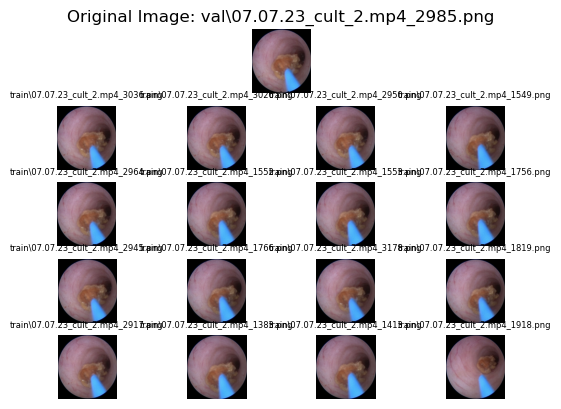

In [52]:
# plot example
path = r'C:\Users\nloma\Desktop\тестовое_почки\test-excercise\datasets\images'

plot_duplicates(image_dir=path,
                duplicate_map=duplicates,
                filename=r'val\07.07.23_cult_2.mp4_2985.png')